In [1]:
dofile './provider.lua'
m = require 'manifold';

In [2]:
provider = torch.load('/home/ubuntu/ajr619/ds-ga-1008-a2/provider.t7')

In [3]:
provider.trainData.data = provider.trainData.data:float()
provider.valData.data = provider.valData.data:float()

In [4]:
trainData = provider.trainData

In [5]:
trainData

{
  data : FloatTensor - size: 4000x3x96x96
  std_u : 13.766151323321
  mean_u : -3.9272570412993
  labels : FloatTensor - size: 4000
  size : function: 0x41004e10
  mean_v : 1.8419336072631
  std_v : 16.746470205287
}


In [25]:
trainData.data:size()

 4000
    3
   96
   96
[torch.LongStorage of size 4]



In [6]:
indices = torch.randperm(provider.trainData.data:size(1))
indices = indices:long()

In [7]:
trainData.labels = trainData.labels:index(1, indices)
trainData.data = trainData.data:index(1, indices)

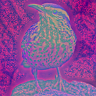

In [8]:
itorch.image(trainData.data[1000])

In [9]:
provider.trainData.data = provider.trainData.data:float()
--itorch.image(provider.valData.data[7])

In [10]:
#trainData.data

 4000
    3
   96
   96
[torch.LongStorage of size 4]



In [11]:
#provider.valData.data

 1000
    3
   96
   96
[torch.LongStorage of size 4]



In [30]:
require 'torch'
require 'unsup'
nCluster=500
nIteration=100
centroids, counts = unsup.kmeans(provider.trainData.data, nCluster, nIteration)


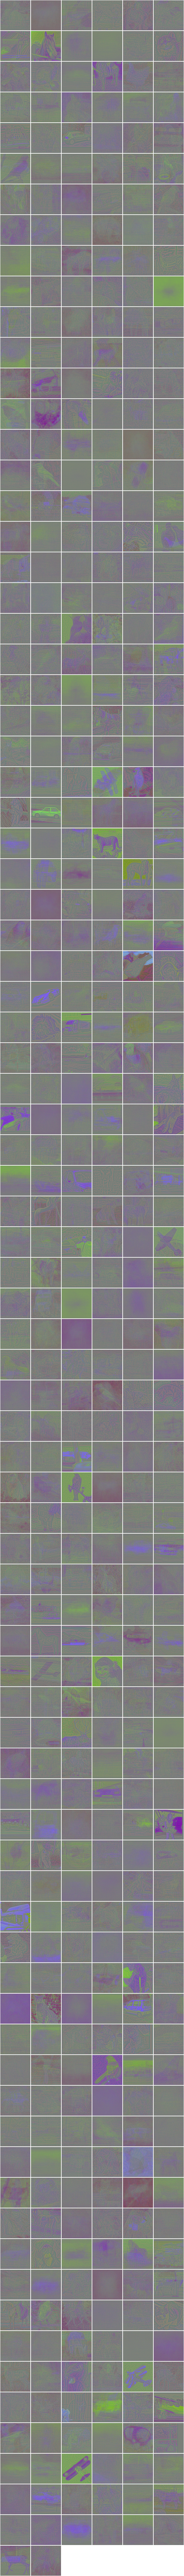

In [49]:
itorch.image(centroids)

In [32]:
--for i=10,20 do print(itorch.image(centroids[i])) end

In [33]:
trainData.data[1000]:size()

  3
 96
 96
[torch.LongStorage of size 3]



In [34]:
patches = torch.rand(12,3,8,8):float()

In [35]:
kSize = 7
numPatches = 4000
patches = torch.zeros(numPatches, kSize*kSize*3)
trsize = 1000
kSize = 7
for i = 1,numPatches do
   xlua.progress(i,numPatches)
   local r = torch.random(96 - kSize + 1)
   local c = torch.random(96 - kSize + 1)
   patches[i] = trainData.data[{math.fmod(i-1,trsize)+1,{},{r,r+kSize-1},{c,c+kSize-1}}]
   patches[i] = patches[i]:add(-patches[i]:mean())
   patches[i] = patches[i]:div(math.sqrt(patches[i]:var()+10))
end



Progress: 1 / 4000	


In [36]:
patches:size()

 4000
  147
[torch.LongStorage of size 2]



In [48]:
if opt.whiten then
   print("==> whiten patches")
   local function zca_whiten(x)
      local dims = x:size()
      local nsamples = dims[1]
      local ndims    = dims[2]
      local M = torch.mean(x, 1)
      local D, V = unsup.pcacov(x)
      x:add(torch.ger(torch.ones(nsamples), M:squeeze()):mul(-1))
      local diag = torch.diag(D:add(0.1):sqrt():pow(-1))
      local P = V * diag * V:t()
      x = x * P
      return x, M, P
   end
   patches, M, P = zca_whiten(patches)
end


print("==> find clusters")
local ncentroids = 1600
kernels, counts = unsup.kmeans_modified(patches, ncentroids, nil, 0.1, 1, 1000, nil, true)

[string "if opt.whiten then..."]:1: attempt to index global 'opt' (a nil value)
stack traceback:
	[string "if opt.whiten then..."]:1: in main chunk
	[C]: in function 'xpcall'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:209: in function </home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:173>
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

In [41]:
--
-- This code is the kmean function in Koray's unsup package and only few lines
-- were modified to implement clustering
--
-- Source: https://github.com/koraykv/unsup
--
require("unsup")

function unsup.kmeans_modified(x, k, centroids, std, niter, batchsize, callback, verbose)
   -- args
   x = x or error('missing argument: ' .. help)
   k = k or error('missing argument: ' .. help)
   niter = niter or 1
   batchsize = batchsize or math.min(1000, (#x)[1])
   std = std or 0.1

   -- some shortcuts
   local sum = torch.sum
   local max = torch.max
   local pow = torch.pow
   local randn = torch.randn
   local zeros = torch.zeros

   -- dims
   local nsamples = (#x)[1]
   local ndims = (#x)[2]

   -- initialize means
   local x2 = sum(pow(x,2),2)
   if not(centroids) then
      centroids = randn(k,ndims)*std
   end
   local totalcounts = zeros(k)

   -- callback?
   if callback then callback(0,centroids:reshape(k_size),totalcounts) end

   -- do niter iterations
   for i = 1,niter do
      -- progress
      if verbose then xlua.progress(i,niter) end

      -- sums of squares
      local c2 = sum(pow(centroids,2),2)*0.5

      -- init some variables
      local summation = zeros(k,ndims)
      local counts = zeros(k)
      local loss = 0

      -- process batch
      for i = 1,nsamples,batchsize do
         -- indices
         local lasti = math.min(i+batchsize-1,nsamples)
         local m = lasti - i + 1

         -- k-means step, on minibatch
         local batch = x[{ {i,lasti},{} }]
         local batch_t = batch:t()
         local tmp = centroids * batch_t
         for n = 1,(#batch)[1] do
            tmp[{ {},n }]:add(-1,c2)
         end
         local val,labels = max(tmp,1)
         loss = loss + sum(x2[{ {i,lasti} }]*0.5 - val:t())

         -- count examplars per template
         local S = zeros(m,k)
         for i = 1,(#labels)[2] do
            S[i][labels[1][i]] = 1
         end
         summation:add( S:t() * batch )
         counts:add( sum(S,1) )
      end

      -- normalize
      for i = 1,k do
         if counts[i] ~= 0 then
            centroids[i] = summation[i]:div(counts[i])
         elseif counts[i] == 0 then
            centroids[i] = centroids[i]*0
         end
      end

      -- total counts
      totalcounts:add(counts)

      -- callback?
      if callback then 
         local ret = callback(i,centroids:reshape(k_size),totalcounts) 
         if ret then break end
      end
   end

   -- done
   return centroids,totalcounts
end

In [46]:
function extract_features(img, kernels, kSize, bias, pmetric, M, P, norm)

   -- shortcuts
   local zeros = torch.zeros
   local ones  = torch.ones
   local ger   = torch.ger

   -- input/output dimensions
   local isample  = img:size(1)
   local ichannel = img:size(2)
   local iheight  = img:size(3)
   local iwidth   = img:size(4)
   local nkernels = kernels:size(1)
   local klength  = kernels:size(2)
   local kheight  = kSize
   local kwidth   = kSize
   local cheight  = iheight - kheight + 1
   local cwidth   = iwidth  - kwidth  + 1
   local npatches = cheight*cwidth

   -- flags
   local norm_  = (norm == nil) or (norm == true)  -- data normalized by default
   local bias_  = not (bias == nil)                -- no bias if not specified
   local whiten = not (P == nil)                   -- no whiten if not specified

   -- init pooling layer
   require 'nnx'
   local pheight = torch.floor(cheight/2)
   local pwidth  = torch.floor(cwidth/2)
   if pmetric == 'max' then
      print '==> max-pooling is applied'
      pooler = nn.SpatialMaxPooling(pwidth, pheight, pwidth, pheight)
   elseif pmetric == 'sum' then
      print '==> L1-pooling is applied'
      pooler = nn.SpatialLPPooling(nkernel, 1, pwidth, pheight, pwidth, pheight)
   end

   local features = zeros(isample, nkernels*4) 
   for k = 1,isample do
      xlua.progress(k, isample)
      -- image to column vectors
      local patches = zeros(npatches, klength)
      for i = 1,cheight do
         for j = 1,cwidth do
            local ptr   = (i-1)*cwidth + j
            local patch = img[{k,{},{i,i+kheight-1},{j,j+kwidth-1}}]
            patches[{ptr,{}}] = patch:reshape(klength)
         end
      end
   
      -- local normalization
      if norm_ then
         local pmean   = ger(patches:mean(2):squeeze(),ones(klength))
         local pstd    = ger(patches:var(2):add(10):sqrt():squeeze(),ones(klength))
         patches = patches:add(pmean:mul(-1)):cdiv(pstd)
      end

      -- whiten
      if whiten then
         patches:add(ger(ones(npatches), M:squeeze()):mul(-1))
         patches = patches * P
      end

      -- extract features by convolution and bias
      local feature = patches * kernels:t()
      if bias_ then feature = feature:add(ger(ones(npatches), bias:squeeze())) end

      -- thresholding
      local threshold = 0
      feature = feature:cmul(torch.gt(feature, threshold):float())
      feature = feature:t():reshape(nkernels,cheight,cwidth)

      -- pooling
      local pooled = pooler:forward(feature)
      pooled = pooled:reshape(nkernels*pooled:size(2)*pooled:size(3))
      -- save feature vector
      features[{k,{}}] = pooled
   end

   return featur

[string "function extract_features(img, kernels, kSize..."]:81: 'end' expected (to close 'function' at line 1) near '<eof>': 

In [47]:
extract_features(trainData.data)

[string "local f = function() return extract_features(..."]:1: attempt to call global 'extract_features' (a nil value)
stack traceback:
	[string "local f = function() return extract_features(..."]:1: in function 'f'
	[string "local f = function() return extract_features(..."]:1: in main chunk
	[C]: in function 'xpcall'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:209: in function </home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:173>
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

In [44]:
x = torch.DoubleTensor(trainData.data:size()):copy(trainData.data)

In [45]:
x:size()

 4000
    3
   96
   96
[torch.LongStorage of size 4]



In [11]:
labels = trainData.labels

In [12]:
labels:size()

 4000
[torch.LongStorage of size 1]



In [13]:
X = x[{{1,100}}]
y = labels[{{1,100}}]

In [14]:
X:resize(X:size(1), X:size(2) * X:size(3) * X:size(4));

In [15]:
X:size(),y:size()

   100
 27648
[torch.LongStorage of size 2]

 100
[torch.LongStorage of size 1]



In [16]:
opts = {ndims = 2, perplexity = 30, pca = 50, use_bh = true, theta=0.5}

In [17]:
m = require 'manifold';

In [18]:
mapped_x1 = m.embedding.tsne(X, opts)

Performing preprocessing using PCA...	


/home/ubuntu/torch/install/share/lua/5.1/manifold/tsne.lua:139: attempt to index local 'f' (a nil value)
stack traceback:
	/home/ubuntu/torch/install/share/lua/5.1/manifold/tsne.lua:139: in function 'run_bhtsne'
	/home/ubuntu/torch/install/share/lua/5.1/manifold/tsne.lua:219: in function 'tsne'
	[string "mapped_x1 = m.embedding.tsne(X, opts)..."]:1: in main chunk
	[C]: in function 'xpcall'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:209: in function </home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:173>
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/ubuntu/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/ubuntu/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

In [ ]:
print "prova"